# REDES NEURONALES CONVOLUCIONALES
---

Se trabaja con Convolutional Neural Networks para resolver un problema de clasificación de imágenes. Se clasifican imágenes de personajes de la conocida serie de los Simpsons.

El dataset a utilizar consiste en imágenes de personajes de los Simpsons extraídas directamente de capítulos de la serie.

El dataset de training puede ser descargado desde aquí:

[Training data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60) (~500MB)

Por otro lado, el dataset de test puede ser descargado de aquí:

[Test data](https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8) (~10MB)


## Carga de los datos

In [3]:
!pip install opencv-python

In [4]:
import cv2
import os
import numpy as np
import keras
from keras.layers import Activation
from tensorflow import keras
import matplotlib.pyplot as plt
import glob
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, models
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import itertools
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation
# from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers.legacy import SGD
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical
from sklearn import metrics



In [5]:
# Primero, bajamos los datos de entrenamiento
keras.utils.get_file(fname="simpsons_train.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219337&authkey=AMzI92bJPx8Sd60")

# Descomprimimos el archivo
!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /root/.keras/datasets


# Hacemos lo mismo con los datos de test
keras.utils.get_file(fname="simpsons_test.tar.gz",
                     origin="https://onedrive.live.com/download?cid=C506CF0A4F373B0F&resid=C506CF0A4F373B0F%219341&authkey=ANnjK3Uq1FhuAe8")
!tar -xzf /root/.keras/datasets/simpsons_test.tar.gz -C /root/.keras/datasets

10658925/10658925 [==============================] - 2s 0us/step


In [6]:
# Descomprimimos el archivo en tmp para visualizar
#!tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons
!mkdir -p /tmp/simpsons && tar -xzf /root/.keras/datasets/simpsons_train.tar.gz -C /tmp/simpsons

Se ha modificado el image size por 64 ya que estaba definido como 60.

In [7]:
# Esta variable contiene un mapeo de número de clase a personaje.
# Utilizamos sólo los 18 personajes del dataset que tienen más imágenes.
MAP_CHARACTERS = {
    0: 'abraham_grampa_simpson', 1: 'apu_nahasapeemapetilon', 2: 'bart_simpson',
    3: 'charles_montgomery_burns', 4: 'chief_wiggum', 5: 'comic_book_guy', 6: 'edna_krabappel',
    7: 'homer_simpson', 8: 'kent_brockman', 9: 'krusty_the_clown', 10: 'lisa_simpson',
    11: 'marge_simpson', 12: 'milhouse_van_houten', 13: 'moe_szyslak',
    14: 'ned_flanders', 15: 'nelson_muntz', 16: 'principal_skinner', 17: 'sideshow_bob'
}

# Vamos a standarizar todas las imágenes a tamaño 64x64
IMG_SIZE = 64

In [8]:
def load_train_set(dirname, map_characters, verbose=True):
    
    X_train = []
    y_train = []
    for label, character in map_characters.items():
        files = os.listdir(os.path.join(dirname, character))
        images = [file for file in files if file.endswith("jpg")]
        if verbose:
          print("Leyendo {} imágenes encontradas de {}".format(len(images), character))
        for image_name in images:
            image = cv2.imread(os.path.join(dirname, character, image_name))
            X_train.append(cv2.resize(image,(IMG_SIZE, IMG_SIZE)))
            y_train.append(label)
    return np.array(X_train), np.array(y_train)

In [9]:
def load_test_set(dirname, map_characters, verbose=True):
    
    X_test = []
    y_test = []
    reverse_dict = {v: k for k, v in map_characters.items()}
    for filename in glob.glob(dirname + '/*.*'):
        char_name = "_".join(filename.split('/')[-1].split('_')[:-1])
        if char_name in reverse_dict:
            image = cv2.imread(filename)
            image = cv2.resize(image, (IMG_SIZE, IMG_SIZE))
            X_test.append(image)
            y_test.append(reverse_dict[char_name])
    if verbose:
        print("Leídas {} imágenes de test".format(len(X_test)))
    return np.array(X_test), np.array(y_test)


In [10]:
# Cargamos los datos. Si no estás trabajando en colab, cambia los paths por
# los de los ficheros donde hayas descargado los datos.
DATASET_TRAIN_PATH_COLAB = "/root/.keras/datasets/simpsons"
DATASET_TEST_PATH_COLAB = "/root/.keras/datasets/simpsons_testset"

X, y = load_train_set(DATASET_TRAIN_PATH_COLAB, MAP_CHARACTERS)
X_t, y_t = load_test_set(DATASET_TEST_PATH_COLAB, MAP_CHARACTERS)

Leyendo 913 imágenes encontradas de abraham_grampa_simpson
Leyendo 623 imágenes encontradas de apu_nahasapeemapetilon
Leyendo 1342 imágenes encontradas de bart_simpson
Leyendo 1193 imágenes encontradas de charles_montgomery_burns
Leyendo 986 imágenes encontradas de chief_wiggum
Leyendo 469 imágenes encontradas de comic_book_guy
Leyendo 457 imágenes encontradas de edna_krabappel
Leyendo 2246 imágenes encontradas de homer_simpson
Leyendo 498 imágenes encontradas de kent_brockman
Leyendo 1206 imágenes encontradas de krusty_the_clown
Leyendo 1354 imágenes encontradas de lisa_simpson
Leyendo 1291 imágenes encontradas de marge_simpson
Leyendo 1079 imágenes encontradas de milhouse_van_houten
Leyendo 1452 imágenes encontradas de moe_szyslak
Leyendo 1454 imágenes encontradas de ned_flanders
Leyendo 358 imágenes encontradas de nelson_muntz
Leyendo 1194 imágenes encontradas de principal_skinner
Leyendo 877 imágenes encontradas de sideshow_bob
Leídas 890 imágenes de test


In [11]:
# Vamos a barajar aleatoriamente los datos. Esto es importante ya que si no
# lo hacemos y, por ejemplo, cogemos el 20% de los datos finales como validation
# set, estaremos utilizando solo un pequeño número de personajes, ya que
# las imágenes se leen secuencialmente personaje a personaje.
perm = np.random.permutation(len(X))
X, y = X[perm], y[perm]

Se ha procedido a normalizar las variables y ha definir el confunto de datos de entrenamiento y el de test.

In [12]:
# Normalizar los valores de píxeles al rango [0, 1]
X_train = X.astype('float32') / 255.0
X_test = X_t.astype('float32') / 255.0

# Codificar las etiquetas a one-hot vectors
y_train = to_categorical(y, num_classes=len(MAP_CHARACTERS))
y_test = to_categorical(y_t, num_classes=len(MAP_CHARACTERS))

# Dividir el conjunto de entrenamiento en entrenamiento y validación
X_tr, X_tst, y_tr, y_tst = train_test_split(X_train, y_train, test_size=0.2, random_state=42)

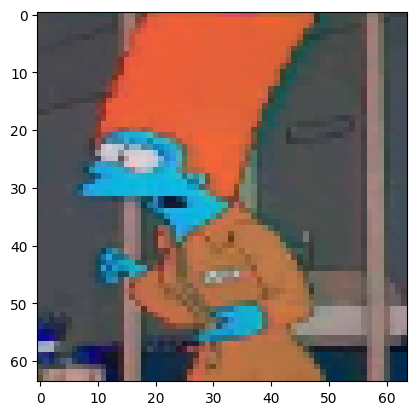

In [13]:
plt.imshow(X_t[20]) # recordad que siempre es preferible trabajar en blanco y negro


## Práctica

Utilizando Convolutional Neural Networks con Keras, entrenar un clasificador que sea capaz de reconocer personajes en imágenes de los Simpsons con una accuracy en el dataset de test de, al menos, **85%**. 

# Análisis de datos

In [14]:
# Obtención de la estructura de datos de entrenamiento
shape_X = X.shape
# Obtención de la estructura de datos de test
shape_X_t = X_t.shape
print(f"El tamaño del conjunto de datos de entrenamiento consta de lo siguiente: {shape_X}")
print(f"El tamaño del conjunto de datos de test consta de lo siguiente: {shape_X_t}")

El tamaño del conjunto de datos de entrenamiento consta de lo siguiente: (18992, 64, 64, 3)
El tamaño del conjunto de datos de test consta de lo siguiente: (890, 64, 64, 3)


Mediante "shape" podemos conocer diferentes propiedades de los conjunto de datos de entrenamiento y test. A continuación la información obtenida:

Conjunto de datos de entrenamiento (X):

*   Elementos: 18992
*   Pixeles de alto de las imágenes: 64 px
*   Pixeles de ancho de las imágenes: 64 px
*   Canales: 3 (Red, Green, Blue) -> RGB

Conjunto de datos de test (X_t):

*   Elementos: 890
*   Pixeles de alto de las imágenes: 64 px
*   Pixeles de ancho de las imágenes: 64 px
*   Canales: 3 (Red, Green, Blue) -> RGB

In [15]:
# Tamaño de los datos de entrenamiento
size_X = X.size
# Tamaño de los datos de test
size_X_t = X_t.size
print(f"Tamaño de los datos de entrenamiento: {size_X}")
print(f"Tamaño de los datos de test: {size_X_t}")

Tamaño de los datos de entrenamiento: 233373696
Tamaño de los datos de test: 10936320


El tamaño que se obtiene a través de la propiedad "size" surge de la multiplicación de todas las dimensiones obtenidas a través de la propiedad "shape".

Conjunto de datos de entrenamiento (X): 18992 x 64 x 64 x 3 = 233373696

Conjunto de datos de test (X_t): 890 x 64 x 64 x 3 = 10936320

In [16]:
# Tipo de datos que componen los datos de entrenamiento
type_X = X.dtype
# Tipo de datos que componen los datos de test
type_X_t = X_t.dtype
print(f"Los tipos de datos que componen los datos de entrenamiento son: {type_X}")
print(f"Los tipos de datos que componen los datos de test son: {type_X_t}")

Los tipos de datos que componen los datos de entrenamiento son: uint8
Los tipos de datos que componen los datos de test son: uint8


Tanto los datos de entrenamiento como los datos de test los componen valores unint8.

Se cogerá el primer elemento de cada conjunto de datos para aplicar alguna propiedad más ya que con un conjunto de 4 dimensiones no es posible.

In [17]:
# Primer elemento del conjunto de datos de entrenamiento
X_0 = X[0]
# Forma del primer elemento del conjunto de datos de entrenamiento
X_0_shape = X[0].shape
print(f"El primer elemento del conjunto de datos de entrenamiento es: \n{X_0}")
print(f"\n La forma del primer elemento del conjunto de datos de entrenamiento es: {X_0_shape}")

El primer elemento del conjunto de datos de entrenamiento es: 
[[[192 149  82]
  [192 149  82]
  [198 148  82]
  ...
  [198 148  82]
  [198 148  82]
  [198 148  82]]

 [[192 149  82]
  [192 149  82]
  [198 148  82]
  ...
  [198 148  82]
  [198 148  82]
  [198 148  82]]

 [[192 149  82]
  [192 149  82]
  [198 148  82]
  ...
  [198 148  82]
  [198 148  82]
  [198 148  82]]

 ...

 [[179 179 179]
  [179 179 179]
  [179 179 179]
  ...
  [149 131 100]
  [143 133  99]
  [143 133  99]]

 [[179 179 179]
  [179 179 179]
  [179 179 179]
  ...
  [150 132  98]
  [146 135 100]
  [146 136 100]]

 [[178 178 178]
  [178 178 178]
  [178 178 178]
  ...
  [142 128  99]
  [146 138 108]
  [146 139 108]]]

 La forma del primer elemento del conjunto de datos de entrenamiento es: (64, 64, 3)


In [18]:
# Primer elemento del conjunto de datos de test
X_0_t = X[0]
# Forma del primer elemento del conjunto de datos de test
X_0_t_shape = X[0].shape
print(f"El primer elemento del conjunto de datos de test es: \n{X_0_t}")
print(f"\n La forma del primer elemento del conjunto de datos de test es: {X_0_t_shape}")

El primer elemento del conjunto de datos de test es: 
[[[192 149  82]
  [192 149  82]
  [198 148  82]
  ...
  [198 148  82]
  [198 148  82]
  [198 148  82]]

 [[192 149  82]
  [192 149  82]
  [198 148  82]
  ...
  [198 148  82]
  [198 148  82]
  [198 148  82]]

 [[192 149  82]
  [192 149  82]
  [198 148  82]
  ...
  [198 148  82]
  [198 148  82]
  [198 148  82]]

 ...

 [[179 179 179]
  [179 179 179]
  [179 179 179]
  ...
  [149 131 100]
  [143 133  99]
  [143 133  99]]

 [[179 179 179]
  [179 179 179]
  [179 179 179]
  ...
  [150 132  98]
  [146 135 100]
  [146 136 100]]

 [[178 178 178]
  [178 178 178]
  [178 178 178]
  ...
  [142 128  99]
  [146 138 108]
  [146 139 108]]]

 La forma del primer elemento del conjunto de datos de test es: (64, 64, 3)


Se obtienen algunas estadisticas descriptivas generales de todas las imágenes al nivel de pixel.

In [19]:
# Importar numpy
import numpy as np
# Calculo de las estadisticas descriptivas
media_X = np.mean(X)
mediana_X = np.median(X)
desv_std_X = np.std(X)
min_X = np.min(X)
max_X = np.max(X)
q1_X = np.percentile(X, 25)
q2_X = np.percentile(X, 50) # es el mismo valor que la mediana
q3_X = np.percentile(X, 75)
iqr_X = q3_X - q1_X
# Imprimir resultados
print(f"Media: {media_X}")
print(f"Mediana: {mediana_X}")
print(f"Desviación estandar: {desv_std_X}")
print(f"Mínimo: {min_X}")
print(f"Máximo: {max_X}")
print(f"Q1: {q1_X}")
print(f"Q2: {q2_X}")
print(f"Q3: {q3_X}")
print(f"IQR: {iqr_X}")

Media: 104.33495513993145
Mediana: 101.0
Desviación estandar: 65.27041043439097
Mínimo: 0
Máximo: 255
Q1: 51.0
Q2: 101.0
Q3: 154.0
IQR: 103.0


Seguidamente, se graficará del primer elemento cuantas veces se repite el valor de cada pixel.

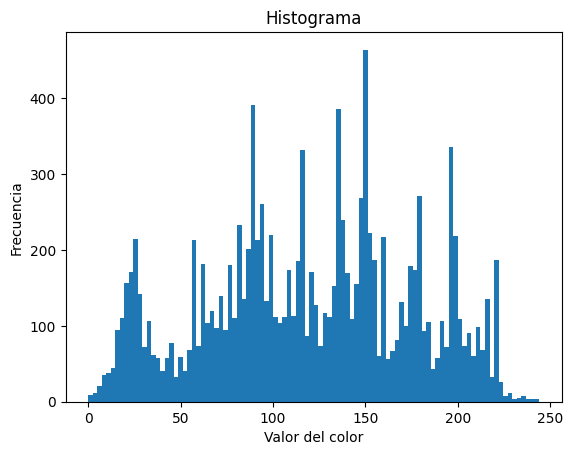

In [20]:
# Suponiendo que tus datos sean un arreglo de una dimensión (por ejemplo, después de aplanar tus imágenes)
plt.hist(X_0.flatten(), bins=100)
plt.xlabel('Valor del color')
plt.ylabel('Frecuencia')
plt.title('Histograma')
plt.show()

In [21]:
# Normalización de datos de entrenamiento
X = X / 255.0
# Normalización de datos de test
X_t = X_t / 255.0
# Dividir el conjunto de entrenamiento en training y validation
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

A continuación se transforman las labels de un número del 1 al 18, posibles clases a las que podía pertenecer la imagen, a un vector donde aparece con la flag "1" la posicion de la clase a la que corresponde la imágen.

In [22]:
# Conversión de los datos de training
vector_y_train = keras.utils.to_categorical(y_train, num_classes = 18)
# Conversión de los datos de validación
vector_y_val = keras.utils.to_categorical(y_val, num_classes = 18)
# Conversión de los datos de test
vector_y_t = keras.utils.to_categorical(y_t, num_classes = 18)

In [23]:
# Comprobación de vector, se incluiría en la clase 5, chief_wiggum
print(vector_y_train[0])

[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


[0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
[0. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]


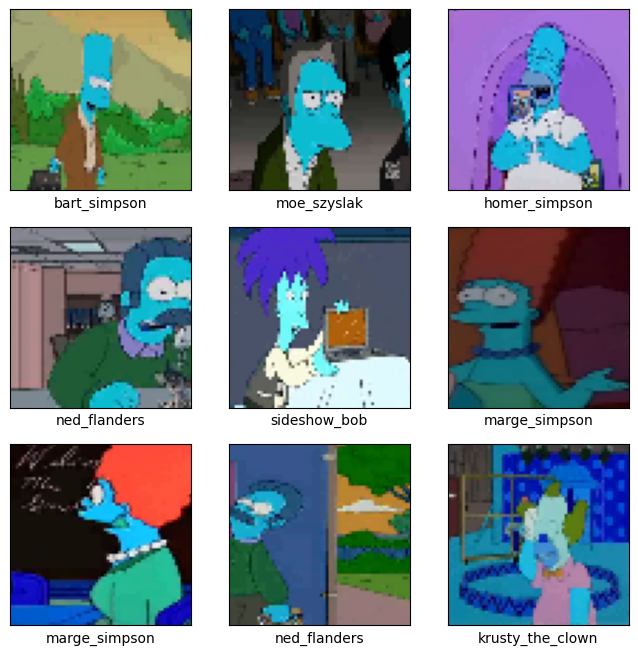

In [24]:
# Se definen las clases
clases = ['abraham_grampa_simpson',
          'apu_nahasapeemapetilon',
          'bart_simpson',
          'charles_montgomery_burns',
          'chief_wiggum',
          'comic_book_guy',
          'edna_krabappel',
          'homer_simpson',
          'kent_brockman',
          'krusty_the_clown',
          'lisa_simpson',
          'marge_simpson',
          'milhouse_van_houten',
          'moe_szyslak',
          'ned_flanders',
          'nelson_muntz',
          'principal_skinner',
          'sideshow_bob']

# Se crea una visualización donde se observa que label tiene cada imagen
plt.figure(figsize=(8,8))
for imagen in range(9):
    plt.subplot(3,3,imagen+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_train[imagen])
    plt.xlabel(clases[y_train[imagen]])
# Se muestran los vectores para ver si coinciden
for imagen in range(9):
  print(vector_y_train[imagen])

Como se puede apreciar los vectores coinciden con la clase asignada a las imágenes.

# Definición del modelo y análisis de los resultados


In [25]:
# Definición de dimensiones de entrada y parámetros del modelo
input_shape = (64, 64, 3)
batch_size = 128
num_classes = 18
epochs = 15

A continuación se presenta el modelo de predicción desarrollado para esta actividad. Se ha realizado un modelo de 19 capas, de las cuales:


- Capas convolucionales (Conv2D): 6.
Detección de características especiales (bordes, texturas, patrones...) dentro de las imagenes de entrada.
- Capas de Activación (ReLu):6.
aplicar una función de activación no lineal que convierte las entradas negativas en 0.
- Capas de Agrupamiento (MaxPooling2D): 3.
Reducción de cantidad de parámetros y costo computacional y control del sobreajuste.
- Capas de Regularización (Dropout): 2.
Prevención del sobreajuste.

- Capas de Aplanado (Flatten): 1.
Preparación de los datos para las capas densas.
- Capas Densas (Dense): 2.
Clasificación final basada en las características extraídas.
- Capas de activación Softmax (Dense + Softmax): 1.
Generar probabilidades de que una imagen pertenezca a una clase para la clasificación final.




In [26]:
# Modelo
model = Sequential()
model.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.2))
model.add(Conv2D(64, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(64, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))
model.add(Conv2D(256, (3, 3), padding='same'))
model.add(Activation('relu'))
model.add(Conv2D(256, (3, 3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation('relu'))

model.add(Dense(num_classes, activation='softmax'))

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 64, 64, 32)        896       
                                                                 
 activation (Activation)     (None, 64, 64, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 62, 62, 32)        9248      
                                                                 
 activation_1 (Activation)   (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d (MaxPooling2  (None, 20, 20, 32)        0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 20, 20, 32)        0         
                                                        

In [27]:
# Compilación del modelo
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [28]:
# Preparación de los datos
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)
# Ajusta datagen con los datos de entrenamiento
datagen.fit(X_tr)

# Entrenamiento del modelo

history = model.fit(
    datagen.flow(X_tr, y_tr, batch_size=batch_size),
    steps_per_epoch=len(X_tr) / batch_size,
    epochs=epochs,
    validation_data=(X_tst, y_tst))


Epoch 1/15
118/118 [==============================] - 36s 230ms/step - loss: 2.5957 - accuracy: 0.1725 - val_loss: 2.1469 - val_accuracy: 0.3085
Epoch 2/15
118/118 [==============================] - 28s 235ms/step - loss: 1.8335 - accuracy: 0.4188 - val_loss: 1.3987 - val_accuracy: 0.5662
Epoch 3/15
118/118 [==============================] - 26s 213ms/step - loss: 1.3390 - accuracy: 0.5849 - val_loss: 1.1234 - val_accuracy: 0.6494
Epoch 4/15
118/118 [==============================] - 21s 176ms/step - loss: 1.0215 - accuracy: 0.6829 - val_loss: 0.8083 - val_accuracy: 0.7470
Epoch 5/15
118/118 [==============================] - 24s 198ms/step - loss: 0.8736 - accuracy: 0.7300 - val_loss: 0.7602 - val_accuracy: 0.7673
Epoch 6/15
118/118 [==============================] - 22s 181ms/step - loss: 0.7374 - accuracy: 0.7690 - val_loss: 0.6501 - val_accuracy: 0.8021
Epoch 7/15
118/118 [==============================] - 23s 198ms/step - loss: 0.6447 - accuracy: 0.8015 - val_loss: 0.5417 - val_ac

Precisión de entrenamiento: 89,02%

Precisión de Validación: 89,68%

Pérdida en entrenamiento: 0,3520.

Pérdida en validación: 0,3518.

Lo que se observa con los resultados obtenidos es que tenemos un buen modelo ya que en la precisión tanto de entrenamiento como de test, se ve un incremento importante desde el primer epoch hasta el último además el valor de la precisión es próximo al 90%. Desde el punto de vista de la pérdida se ve que hay una disminución desde la primera etapa hasta la última y eso indica un buen rendimiento. El modelo también tiene unos valores de pérdida y precisión muy similar tanto para datos de entreno como para datos de test y esto ayuda a poder evitar el sobreajuste.
Se podría decir que el modelo tiene un aprendizaje efectivo y generaliza correctamente los datos de validación.

In [29]:

# Evaluar el modelo
score = model.evaluate(X_tst, y_tst, verbose=0)
print('\nKeras CNN - accuracy:', score[1])
print('')

# Generar predicciones
y_pred = model.predict(X_tst)

# Mostrar el reporte de clasificación
print('\n', metrics.classification_report(
    np.argmax(y_tst, axis=1), np.argmax(y_pred, axis=1),
    target_names=list(MAP_CHARACTERS.values())
), sep='')

# Obtener las clases predichas y verdaderas
Y_pred_classes = np.argmax(y_pred, axis=1)
Y_true = np.argmax(y_tst, axis=1)


Keras CNN - accuracy: 0.8968149423599243

119/119 [==============================] - 1s 5ms/step

                          precision    recall  f1-score   support

  abraham_grampa_simpson       0.87      0.87      0.87       166
  apu_nahasapeemapetilon       0.88      0.93      0.90       115
            bart_simpson       0.81      0.86      0.83       250
charles_montgomery_burns       0.83      0.77      0.80       233
            chief_wiggum       0.87      0.94      0.90       180
          comic_book_guy       0.90      0.74      0.81        97
          edna_krabappel       0.94      0.80      0.87        85
           homer_simpson       0.91      0.89      0.90       452
           kent_brockman       0.94      0.93      0.93       110
        krusty_the_clown       0.95      0.96      0.95       254
            lisa_simpson       0.92      0.80      0.85       284
           marge_simpson       0.93      0.98      0.95       275
     milhouse_van_houten       0.95      0

Se puede observar por los resultados de la precisión global que el modelo es efectivo en la clasificación de la mayoría de las imágenes.
Se puede apreciar que los personajes que son más faciles de reconocer son:
- apu_nahasapeemapetilon: precisión 88%, recall de 96% f1-score de 90%. Esto indica que proporciona un excelente rendimiento de clasificación.
- Krusty_the_clown: Precisión 95%, recall de 96%, f1-score 95%
- ned_flanders: precisión y recall de 98% y 95%, f1-score de 96%
- Kent_brockman: precisión 94%, recall 93% y f1-score 93%

A continuación observamos las clases con peor rendimiento:
- bart_simpson: precisión 81%, recall 86% f1-score 83%.
- chief_wiggum: precisión 87%, recall 94%, f1-score 90%.
- moe_szyslak: precisión 77%.

El modelo identifica bien las instancias de moe_szyslak (precisión 77%) y encuentra la mayoría de ellas (recall 92%), manteniendo un buen equilibrio entre ambas (F1-Score 83%), aunque puede mejorar en reducir errores en predicciones positivas. Esto puede deberse a que las imágenes que esta clase son más "difíciles" de interpretar que las de otras clases.

El modelo muestra una buena precisión y recall en casi todas las clases, siendo la media del 90% y del 89%, respectivamente, las cuales están por encima del 85%. Por tanto, se podría afirmar que el modelo está aprendiendo de manera efectiva.

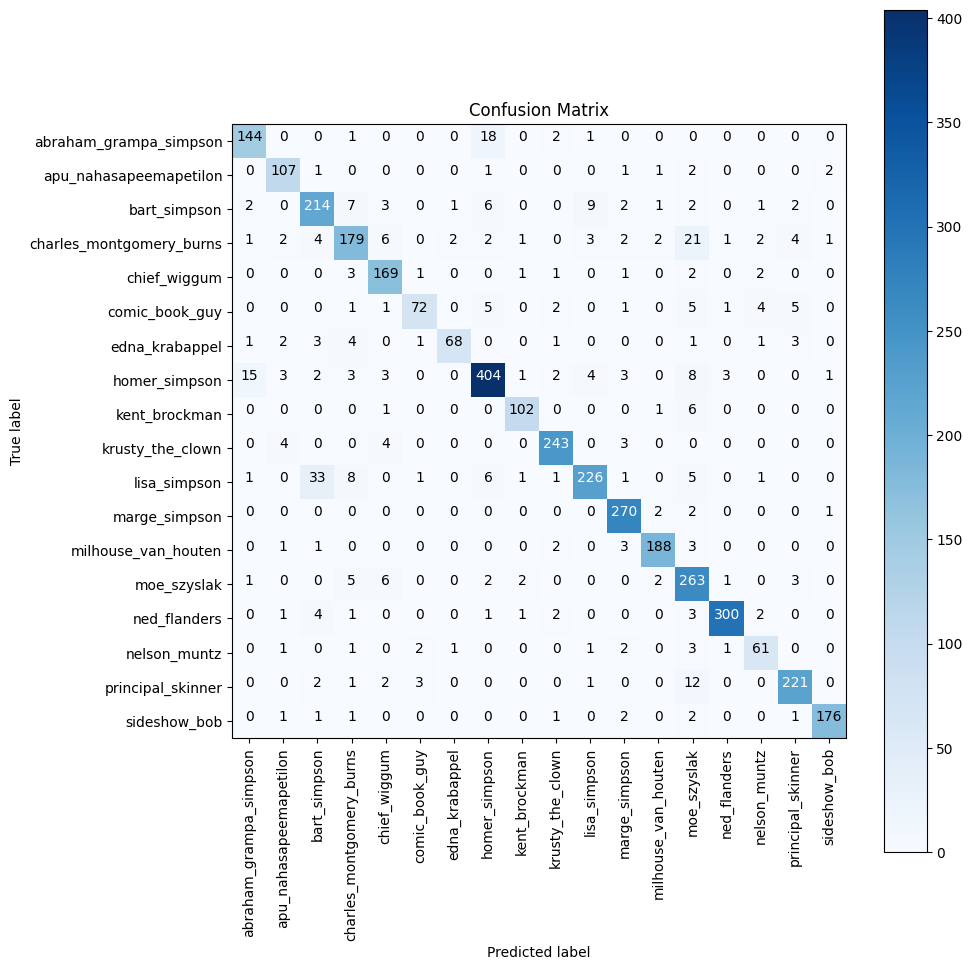

In [30]:
# Matriz de confusión
cm = metrics.confusion_matrix(np.argmax(y_tst, axis=1), np.argmax(y_pred, axis=1))

# Grafica
plt.figure(figsize=(10, 10))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = np.arange(len(clases))
plt.xticks(tick_marks, clases, rotation=90)
plt.yticks(tick_marks, clases)

if False:  # Set to True to normalize
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]

thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, format(cm[i, j], 'd'), horizontalalignment="center",
             color="white" if cm[i, j] > thresh else "black")

plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


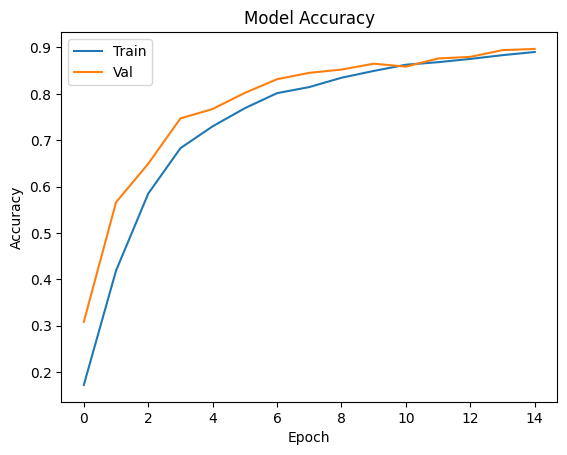

In [31]:
# Grafica precisión del modelo
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper left')
plt.show()


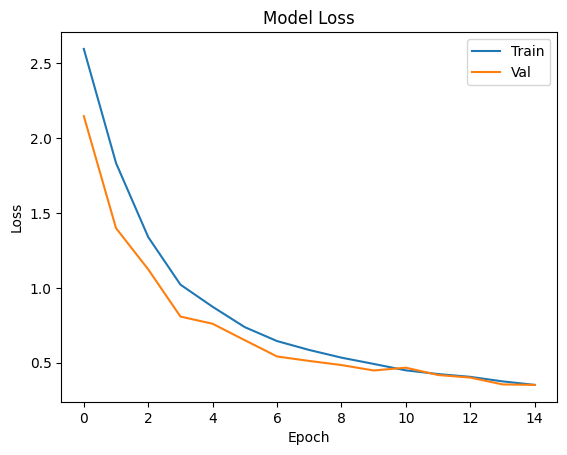

In [32]:
# Graficar pérdida del modelo
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val'], loc='upper right')
plt.show()

En resumen el modelo está funcionando bien con una precisión global próxima al 90% pero sí que se podría aplicar alguna mejora para que las clases con peor resultado puedan presentar una mejora en la generalización y en las métricas.

## Desarrollo de modelos CNN y Fully Connected
A continuación, se desarrollan dos modelos:
- Un modelo de Red Neuronal Convolucional, muy útil para captar características espaciales y patrones de las imágenes. Además son menos propensas al overfitting comparadas con las Redes Fully Connected.
- Un modelo de Red Fully Connected, donde las neuronas están conectadas con todas las de la capa siguiente, y generalmente son menos efectivas que las CNN para captar patrones en imágenes.

### Modelo CNN

In [33]:
# Definición de modelo CNN
def create_cnn_model(input_shape):
    model = models.Sequential()
    model.add(layers.Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
    model.add(Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(128, (3, 3), padding='same'))
    model.add(Activation('relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(layers.Dense(256))
    model.add(layers.Dense(18, activation='softmax'))
    return model

input_shape = (64, 64, 3)
cnn_model = create_cnn_model(input_shape)

cnn_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

cnn_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_6 (Conv2D)           (None, 64, 64, 32)        896       
                                                                 
 activation_7 (Activation)   (None, 64, 64, 32)        0         
                                                                 
 dropout_2 (Dropout)         (None, 64, 64, 32)        0         
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 32, 32, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_7 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 activation_8 (Activation)   (None, 32, 32, 64)        0         
                                                      

In [34]:
# Utilización de data augmentation con la clase ImageDataGenerator de Keras
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True
)

datagen.fit(X_train)

# Entrenamiento del modelo CNN
history_cnn = cnn_model.fit(datagen.flow(X_train, y_train, batch_size=32), epochs=20, validation_data=(X_val, y_val))

Epoch 1/20
475/475 [==============================] - 27s 53ms/step - loss: 2.4032 - accuracy: 0.2722 - val_loss: 2.4111 - val_accuracy: 0.3785
Epoch 2/20
475/475 [==============================] - 23s 49ms/step - loss: 1.7565 - accuracy: 0.4725 - val_loss: 1.9609 - val_accuracy: 0.5736
Epoch 3/20
475/475 [==============================] - 24s 51ms/step - loss: 1.4065 - accuracy: 0.5784 - val_loss: 1.6430 - val_accuracy: 0.6307
Epoch 4/20
475/475 [==============================] - 23s 49ms/step - loss: 1.2073 - accuracy: 0.6431 - val_loss: 1.5605 - val_accuracy: 0.6660
Epoch 5/20
475/475 [==============================] - 24s 51ms/step - loss: 1.0452 - accuracy: 0.6862 - val_loss: 1.5045 - val_accuracy: 0.6583
Epoch 6/20
475/475 [==============================] - 24s 50ms/step - loss: 0.9673 - accuracy: 0.7122 - val_loss: 1.3393 - val_accuracy: 0.7194
Epoch 7/20
475/475 [==============================] - 23s 48ms/step - loss: 0.8941 - accuracy: 0.7319 - val_loss: 1.2539 - val_accuracy:

### Modelo Fully Connected

In [35]:
# Definición de modelo Fully Connected
def create_fully_connected_model(input_shape):
    model = models.Sequential()
    model.add(layers.Flatten(input_shape=input_shape))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(512, activation='relu'))
    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.Dense(18, activation='softmax'))
    return model

input_shape = (64, 64, 3)
fc_model = create_fully_connected_model(input_shape)

fc_model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

fc_model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_2 (Flatten)         (None, 12288)             0         
                                                                 
 dense_4 (Dense)             (None, 512)               6291968   
                                                                 
 dense_5 (Dense)             (None, 512)               262656    
                                                                 
 dense_6 (Dense)             (None, 256)               131328    
                                                                 
 dense_7 (Dense)             (None, 128)               32896     
                                                                 
 dense_8 (Dense)             (None, 18)                2322      
                                                                 
Total params: 6721170 (25.64 MB)
Trainable params: 672

In [36]:
# Entrenamiento del modelo Fully Connected
history_fc = fc_model.fit(X_train, y_train, epochs=20, batch_size=32, validation_data=(X_val, y_val))

Epoch 1/20
475/475 [==============================] - 6s 9ms/step - loss: 2.5559 - accuracy: 0.2142 - val_loss: 2.3105 - val_accuracy: 0.2856
Epoch 2/20
475/475 [==============================] - 3s 6ms/step - loss: 2.0866 - accuracy: 0.3579 - val_loss: 2.0541 - val_accuracy: 0.3735
Epoch 3/20
475/475 [==============================] - 3s 6ms/step - loss: 1.9375 - accuracy: 0.4041 - val_loss: 1.9072 - val_accuracy: 0.4275
Epoch 4/20
475/475 [==============================] - 3s 6ms/step - loss: 1.8201 - accuracy: 0.4384 - val_loss: 1.9830 - val_accuracy: 0.3988
Epoch 5/20
475/475 [==============================] - 4s 8ms/step - loss: 1.7087 - accuracy: 0.4729 - val_loss: 1.9045 - val_accuracy: 0.4172
Epoch 6/20
475/475 [==============================] - 3s 6ms/step - loss: 1.6255 - accuracy: 0.5004 - val_loss: 1.7866 - val_accuracy: 0.4601
Epoch 7/20
475/475 [==============================] - 3s 6ms/step - loss: 1.5439 - accuracy: 0.5268 - val_loss: 1.7807 - val_accuracy: 0.4746
Epoch 

### Evaluación de los modelos

In [37]:
# Evaluación del modelo CNN
test_loss_cnn, test_acc_cnn = cnn_model.evaluate(X_t, y_t)
print(f'Precisión del modelo CNN en el conjunto de test: {test_acc_cnn * 100:.2f}%')


28/28 [==============================] - 0s 12ms/step - loss: 1.1296 - accuracy: 0.7831
Precisión del modelo CNN en el conjunto de test: 78.31%


In [38]:
# Evaluación del modelo Fully Connected
test_loss_fc, test_acc_fc = fc_model.evaluate(X_t, y_t)
print(f'Precisión del modelo Fully Connected en el conjunto de test: {test_acc_fc * 100:.2f}%')


28/28 [==============================] - 0s 3ms/step - loss: 1.1674 - accuracy: 0.6528
Precisión del modelo Fully Connected en el conjunto de test: 65.28%


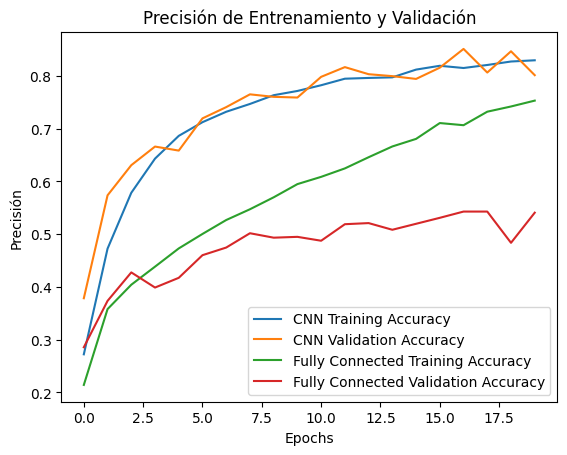

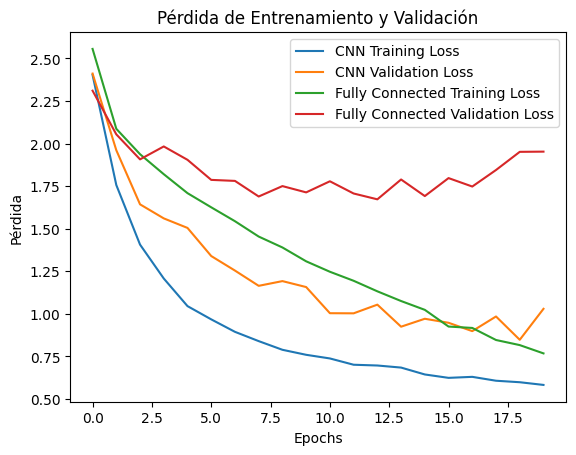

In [39]:
import matplotlib.pyplot as plt

# Precisión
plt.plot(history_cnn.history['accuracy'], label='CNN Training Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='CNN Validation Accuracy')
plt.plot(history_fc.history['accuracy'], label='Fully Connected Training Accuracy')
plt.plot(history_fc.history['val_accuracy'], label='Fully Connected Validation Accuracy')
plt.title('Precisión de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Precisión')
plt.legend()
plt.show()

# Pérdida
plt.plot(history_cnn.history['loss'], label='CNN Training Loss')
plt.plot(history_cnn.history['val_loss'], label='CNN Validation Loss')
plt.plot(history_fc.history['loss'], label='Fully Connected Training Loss')
plt.plot(history_fc.history['val_loss'], label='Fully Connected Validation Loss')
plt.title('Pérdida de Entrenamiento y Validación')
plt.xlabel('Epochs')
plt.ylabel('Pérdida')
plt.legend()
plt.show()


Comparando los modelos y tras la ejecuciónde cada uno de ellos, se puede observar que:
- El entrenamiento de los modelos CNN es mucho más costoso que el de los modelos Fully Connected.
- En el caso de los modelos CNN es posible emplear filtros que mejoran el rendimiento y eficiencia dle modelo.
- En el caso de CNN, no se necesitan tantos epochs en comparación con los modelos Fully Connected, que necesitan de más iteraciones.
- Por lo general, para identificar patrones en imágenes, las CNN obtienen mejores resultados frente a las redes Fully Connected.

# Utilización de distintas arquitecturas CNN

A continuación se realizan diferentes pruebas de CNN modificando la arquitectura de la red y los hiperparámetros para ver si se puede conseguir un resultado más óptimo.

In [40]:
# Definición de dimensiones de entrada
input_shape = (64, 64, 3)
batch_size = 128
num_classes = 18

## 1: hacer downsampling aplicando stride en lugar de utilizar pooling layers

El objetivo de esta arquitectura es sustituir la forma de hacer downsampling conforme avanzan las capas del modelo. En lugar de añadir pooling layers se han utilizado 4 capas de convolución, cada una con un stride de 2. El uso de este stride tiene como efecto que el tamaño de la salida se reduce a la mitad. Se ha aplicado padding en todas las capas. Por último se ha añadido una capa densa adicional.

In [41]:
# Parámetros de entrenamiento
epochs = 15
# indicamos un stride de 2
stride = (2,2)
# como padding indicamos "same" para que lo aplique igual en todos los bordes, el valor por defecto es "valid" (= sin padding)
padding = "same"

# Modelo
modelAlt1 = Sequential()
modelAlt1.add(Conv2D(32, (3, 3), input_shape=input_shape, strides=stride, padding=padding))
modelAlt1.add(Activation('relu'))

modelAlt1.add(Conv2D(32, (3, 3), strides=stride, padding=padding))
modelAlt1.add(Activation('relu'))

modelAlt1.add(Conv2D(64, (3, 3), strides=stride, padding=padding))
modelAlt1.add(Activation('relu'))

modelAlt1.add(Conv2D(64, (3, 3), strides=stride, padding=padding))
modelAlt1.add(Activation('relu'))

modelAlt1.add(Flatten())
modelAlt1.add(Dense(1024))
modelAlt1.add(Dense(1024))
modelAlt1.add(Activation('relu'))

modelAlt1.add(Dense(num_classes, activation='softmax'))

modelAlt1.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_9 (Conv2D)           (None, 32, 32, 32)        896       
                                                                 
 activation_10 (Activation)  (None, 32, 32, 32)        0         
                                                                 
 conv2d_10 (Conv2D)          (None, 16, 16, 32)        9248      
                                                                 
 activation_11 (Activation)  (None, 16, 16, 32)        0         
                                                                 
 conv2d_11 (Conv2D)          (None, 8, 8, 64)          18496     
                                                                 
 activation_12 (Activation)  (None, 8, 8, 64)          0         
                                                                 
 conv2d_12 (Conv2D)          (None, 4, 4, 64)         

In [42]:
# Compilación del modelo
modelAlt1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)
# Ajusta datagen con los datos de entrenamiento
datagen.fit(X_tr)

# Entrenamiento del modelo

history = modelAlt1.fit(
    datagen.flow(X_tr, y_tr, batch_size=batch_size),
    steps_per_epoch=len(X_tr) / batch_size,
    epochs=epochs,
    validation_data=(X_tst, y_tst))

Epoch 1/15
118/118 [==============================] - 25s 184ms/step - loss: 2.4217 - accuracy: 0.2433 - val_loss: 1.9069 - val_accuracy: 0.4280
Epoch 2/15
118/118 [==============================] - 19s 164ms/step - loss: 1.7559 - accuracy: 0.4688 - val_loss: 1.4543 - val_accuracy: 0.5636
Epoch 3/15
118/118 [==============================] - 21s 179ms/step - loss: 1.4153 - accuracy: 0.5681 - val_loss: 1.2809 - val_accuracy: 0.6199
Epoch 4/15
118/118 [==============================] - 20s 165ms/step - loss: 1.1981 - accuracy: 0.6321 - val_loss: 1.0810 - val_accuracy: 0.6702
Epoch 5/15
118/118 [==============================] - 21s 177ms/step - loss: 1.0549 - accuracy: 0.6752 - val_loss: 0.9539 - val_accuracy: 0.7089
Epoch 6/15
118/118 [==============================] - 19s 163ms/step - loss: 0.9339 - accuracy: 0.7085 - val_loss: 0.8972 - val_accuracy: 0.7257
Epoch 7/15
118/118 [==============================] - 21s 177ms/step - loss: 0.8474 - accuracy: 0.7365 - val_loss: 0.8564 - val_ac

Como se puede observar, tras 15 epochs, la precisión del modelo es del 83%. Este resultado es peor que el del modelo original que aplicaba pooling layers.

## 2: aplicar pooling layer cada 3 capas de convolución

El objetivo de esta arquitectura es comprobar el comportamiento del modelo si sólo hacemos downsampling cada 3 capas de convolución. En total se aplican 6 capas de convolución con 2 fases de downsampling:

In [43]:
# Parámetros de entrenamiento
epochs = 15
# indicamos un stride de 1
stride = (1,1)
# como padding indicamos "same" para que lo aplique igual en todos los bordes, el valor por defecto es "valid" (= sin padding)
padding = "same"

# Modelo
modelAlt2 = Sequential()

modelAlt2.add(Conv2D(32, (3, 3), input_shape=input_shape, strides=stride, padding=padding))
modelAlt2.add(Activation('relu'))
modelAlt2.add(Conv2D(32, (3, 3), strides=stride, padding=padding))
modelAlt2.add(Activation('relu'))
modelAlt2.add(Conv2D(64, (3, 3), strides=stride, padding=padding))
modelAlt2.add(Activation('relu'))
modelAlt2.add(layers.MaxPooling2D((2, 2)))

modelAlt2.add(Conv2D(64, (3, 3), strides=stride, padding=padding))
modelAlt2.add(Activation('relu'))
modelAlt2.add(Conv2D(32, (3, 3), strides=stride, padding=padding))
modelAlt2.add(Activation('relu'))
modelAlt2.add(Conv2D(64, (3, 3), strides=stride, padding=padding))
modelAlt2.add(Activation('relu'))
modelAlt2.add(layers.MaxPooling2D((2, 2)))


modelAlt2.add(Flatten())
modelAlt2.add(Dense(1024))
modelAlt2.add(Dense(1024))
modelAlt2.add(Activation('relu'))

modelAlt2.add(Dense(num_classes, activation='softmax'))

modelAlt2.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_13 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 activation_15 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 conv2d_14 (Conv2D)          (None, 64, 64, 32)        9248      
                                                                 
 activation_16 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 conv2d_15 (Conv2D)          (None, 64, 64, 64)        18496     
                                                                 
 activation_17 (Activation)  (None, 64, 64, 64)        0         
                                                                 
 max_pooling2d_6 (MaxPoolin  (None, 32, 32, 64)       

In [44]:
# Compilación del modelo
modelAlt2.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)
# Ajusta datagen con los datos de entrenamiento
datagen.fit(X_tr)

# Entrenamiento del modelo

history = modelAlt2.fit(
    datagen.flow(X_tr, y_tr, batch_size=batch_size),
    steps_per_epoch=len(X_tr) / batch_size,
    epochs=epochs,
    validation_data=(X_tst, y_tst))

Epoch 1/15
118/118 [==============================] - 33s 222ms/step - loss: 2.3728 - accuracy: 0.2658 - val_loss: 1.8414 - val_accuracy: 0.4312
Epoch 2/15
118/118 [==============================] - 23s 197ms/step - loss: 1.6066 - accuracy: 0.5100 - val_loss: 1.3025 - val_accuracy: 0.5983
Epoch 3/15
118/118 [==============================] - 22s 184ms/step - loss: 1.2217 - accuracy: 0.6288 - val_loss: 0.9570 - val_accuracy: 0.7141
Epoch 4/15
118/118 [==============================] - 24s 200ms/step - loss: 0.9164 - accuracy: 0.7245 - val_loss: 0.8872 - val_accuracy: 0.7402
Epoch 5/15
118/118 [==============================] - 23s 195ms/step - loss: 0.7666 - accuracy: 0.7682 - val_loss: 0.7095 - val_accuracy: 0.7807
Epoch 6/15
118/118 [==============================] - 24s 201ms/step - loss: 0.6174 - accuracy: 0.8137 - val_loss: 0.5901 - val_accuracy: 0.8181
Epoch 7/15
118/118 [==============================] - 23s 190ms/step - loss: 0.5658 - accuracy: 0.8299 - val_loss: 0.6062 - val_ac

Como se puede observar, aunque se alcance el 85% de precisión tras 15 epochs, el resultado final sigue siendo peor que el alcanzado con la arquitectura original planteada en este documento.

## 3: Modificación capas densas y optimizador

Para esta arquitectura se parte también del modelo original. En este caso se realizan las siguientes modificaciones:

- Utilización de 4 capas densas de 128 neuronas cada una.
- Se modifica el algoritmo de inicialización del kernel y del bias de las capas densas a glorot uniform
- Se modifica el optimizador a la hora de compilar a Nadam.

In [45]:
# Parámetros de entrenamiento
epochs = 15
# indicamos un stride de 1
stride = (1,1)
# como padding indicamos "same" para que lo aplique igual en todos los bordes, el valor por defecto es "valid" (= sin padding)
padding = "same"

# Modelo
modelAlt3 = Sequential()
modelAlt3.add(Conv2D(32, (3, 3), padding='same', input_shape=input_shape))
modelAlt3.add(Activation('relu'))
modelAlt3.add(Conv2D(32, (3, 3)))
modelAlt3.add(Activation('relu'))
modelAlt3.add(MaxPooling2D(pool_size=(3, 3)))
modelAlt3.add(Dropout(0.2))
modelAlt3.add(Conv2D(64, (3, 3), padding='same'))
modelAlt3.add(Activation('relu'))
modelAlt3.add(Conv2D(64, (3, 3)))
modelAlt3.add(Activation('relu'))
modelAlt3.add(MaxPooling2D(pool_size=(2, 2)))
modelAlt3.add(Dropout(0.5))
modelAlt3.add(Conv2D(256, (3, 3), padding='same'))
modelAlt3.add(Activation('relu'))
modelAlt3.add(Conv2D(256, (3, 3)))
modelAlt3.add(Activation('relu'))
modelAlt3.add(MaxPooling2D(pool_size=(2, 2)))

modelAlt3.add(Flatten())
modelAlt3.add(Dense(128,activation='relu',kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
modelAlt3.add(Dense(128,activation='relu',kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
modelAlt3.add(Dense(128,activation='relu',kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))
modelAlt3.add(Dense(128,activation='relu',kernel_initializer='glorot_uniform', bias_initializer='glorot_uniform'))

modelAlt3.add(Dense(num_classes, activation='softmax'))

modelAlt3.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_19 (Conv2D)          (None, 64, 64, 32)        896       
                                                                 
 activation_22 (Activation)  (None, 64, 64, 32)        0         
                                                                 
 conv2d_20 (Conv2D)          (None, 62, 62, 32)        9248      
                                                                 
 activation_23 (Activation)  (None, 62, 62, 32)        0         
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 20, 20, 32)        0         
 g2D)                                                            
                                                                 
 dropout_5 (Dropout)         (None, 20, 20, 32)        0         
                                                      

In [46]:
# Compilación del modelo
modelAlt3.compile(optimizer='Nadam', loss='categorical_crossentropy', metrics=['accuracy'])

# Data augmentation
datagen = keras.preprocessing.image.ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=10,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=False)
# Ajusta datagen con los datos de entrenamiento
datagen.fit(X_tr)

# Entrenamiento del modelo

history = modelAlt3.fit(
    datagen.flow(X_tr, y_tr, batch_size=batch_size),
    steps_per_epoch=len(X_tr) / batch_size,
    epochs=epochs,
    validation_data=(X_tst, y_tst))

Epoch 1/15
118/118 [==============================] - 30s 187ms/step - loss: 2.7003 - accuracy: 0.1572 - val_loss: 2.3145 - val_accuracy: 0.2930
Epoch 2/15
118/118 [==============================] - 21s 176ms/step - loss: 2.0121 - accuracy: 0.3729 - val_loss: 1.5395 - val_accuracy: 0.5130
Epoch 3/15
118/118 [==============================] - 23s 192ms/step - loss: 1.4361 - accuracy: 0.5537 - val_loss: 1.1911 - val_accuracy: 0.6236
Epoch 4/15
118/118 [==============================] - 22s 188ms/step - loss: 1.1151 - accuracy: 0.6556 - val_loss: 0.9160 - val_accuracy: 0.7191
Epoch 5/15
118/118 [==============================] - 23s 192ms/step - loss: 0.9211 - accuracy: 0.7168 - val_loss: 0.7588 - val_accuracy: 0.7663
Epoch 6/15
118/118 [==============================] - 25s 207ms/step - loss: 0.7929 - accuracy: 0.7565 - val_loss: 0.6411 - val_accuracy: 0.8028
Epoch 7/15
118/118 [==============================] - 21s 180ms/step - loss: 0.6972 - accuracy: 0.7829 - val_loss: 0.6012 - val_ac

Tras las modificaciones realizadas en el optimizador y las capas el resultado, aunque bueno (alcanza un 88% de precisión), sigue sin mejorar al del modelo original.